<a href="https://colab.research.google.com/github/Travoltah/Covid-19-Prediction-from-Chest-X-Ray-Images/blob/main/COVID_PREDICTION_C1212026T.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Author Details

- Trevor Kauyu                    - C1213036T
- Email                           - tkauyu@gmail.com


# Covid 19 Prediction from Chest X-Ray Images

This Python code is a comprehensive script for building and evaluating a Convolutional Neural Network (CNN) model to predict COVID-19, No COVID-19, and Pneumonia from chest X-ray images. Here's a detailed summary:

**1. Setup and Imports:**

- **Library Imports:** The code begins by importing necessary libraries for data manipulation (NumPy, Pandas), image processing (OpenCV, Matplotlib), deep learning (TensorFlow, Keras), model evaluation (Scikit-learn), and file system operations (os).
- **Configuration:** It sets a random seed for reproducibility and initializes various parameters like `IMAGE_SIZE`, `NUM_CLASSES`, `BATCH_SIZE`, `NUM_EPOCHS`, and `LEARNING_RATE`.
- **Warnings:** It filters out warnings to keep the output clean.

**2. Exploratory Data Analysis (EDA):**

- **Data Path:** Sets the input path to the dataset containing the X-ray images, categorized into 'train' and 'val' sets, and further into 'No_Covid-19', 'Covid-19', and 'Pneumonia'.
- **Image Visualization:** Displays sample images from each category ('No_Covid-19', 'Covid-19', and 'Pneumonia') for both the training and validation sets using Matplotlib. This provides a visual understanding of the data.
- **Dataset Distribution:** Prints the number of images in each category for the training and validation sets to show the distribution of the classes.

**3. Data Preparation and Augmentation:**

- **ImageDataGenerator:** Initializes an `ImageDataGenerator` object. This is a crucial step for data augmentation, which helps in increasing the size and diversity of the training dataset by applying random transformations (rotation, shifting, shearing, zooming, flipping, etc.) to the images. It also handles image rescaling.
- **Data Loading:** Uses `flow_from_directory` to load images from the specified training directory (`input_path_TRAIN`). It automatically infers the labels based on the directory structure.
- **Training and Validation Batches:** Creates `train_batches` and `valid_batches` using the `ImageDataGenerator`. These generators provide batches of augmented images and their corresponding labels to the model during training and validation. The dataset is split into training and validation sets based on the `validation_split` parameter.

**4. Model Building (VGG16 with Transfer Learning):**

- **Transfer Learning:** Utilizes the pre-trained VGG16 convolutional base from the `imagenet` dataset. This is a common transfer learning technique where a model trained on a large dataset is used as a starting point for a new task.
- **Freezing Layers:** Sets `conv_base.trainable = False` to freeze the weights of the pre-trained VGG16 layers. This prevents the pre-trained weights from being updated during the initial training phase, preserving the learned features.
- **Building the Classifier:** Constructs a sequential model by adding the VGG16 convolutional base followed by flattening the output and adding several dense layers with ReLU activation. Dropout layers are included to prevent overfitting. The final dense layer has 3 neurons (corresponding to the three classes) and a softmax activation for multi-class classification.
- **Model Compilation:** Compiles the model using the Adam optimizer, categorical cross-entropy loss (suitable for multi-class classification), and 'acc' (accuracy) as the evaluation metric.

**5. Training the Model:**

- **Callbacks:** Defines callbacks for training:
    - `ModelCheckpoint`: Saves the model's weights only when there is an improvement in the validation accuracy.
    - `ReduceLROnPlateau`: Reduces the learning rate when the accuracy plateaus, helping the model to converge further.
    - `EarlyStopping`: Stops the training early if the accuracy does not improve for a certain number of epochs (optional, commented out in the provided code).
- **Training Execution:** Trains the model using `fit_generator`, which takes the training and validation data generators as input. It specifies the number of steps per epoch and the total number of epochs. Callbacks are passed to monitor the training process.

**6. Evaluation and Prediction:**

- **Training History Plot:** Plots the training and validation loss and accuracy over the epochs using Matplotlib. This visualization helps in understanding the model's performance during training and identifying potential overfitting or underfitting.
- **Model Saving:** Saves the trained model to a file (`Covid_model_Predictor.h5`) in HDF5 format.
- **Prediction on Validation Set:** Generates predictions on the validation set using `predict_generator`.
- **Classification Report:** Calculates and prints a detailed classification report using Scikit-learn's `classification_report`. This report includes precision, recall, F1-score, and support for each class, providing a comprehensive evaluation of the model's performance.
- **Testing with a Single Image:** Loads a test image, preprocesses it, and uses the trained model to predict the class of the image. It then prints the predicted class.

**7. Fine-Tuning (Optional):**

- **Unfreezing Layers (Implicit):** Although not explicitly shown by setting `conv_base.trainable = True`, the commented-out section for fine-tuning would typically involve unfreezing some or all layers of the convolutional base and retraining the model with a smaller learning rate to further improve performance by adapting the pre-trained weights to the specific dataset.
- **Retraining:** Retrains the model with a potentially lower learning rate for a few more epochs.
- **Evaluation after Fine-Tuning:** Evaluates the fine-tuned model on the validation set.

**Overall, this code provides a standard workflow for image classification using deep learning, including data loading, augmentation, transfer learning with a pre-trained VGG16 model, training, evaluation, and prediction.**

In [ ]:
# General libraries
import os
import numpy as np
import pandas as pd
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# Deep learning libraries
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf


# import warnings
import warnings
# filter warnings
warnings.filterwarnings('ignore')

# Setting seeds for reproducibility
seed = 232
np.random.seed(seed)
#np.set_random_seed(seed)

## Exploratory Data Analysis

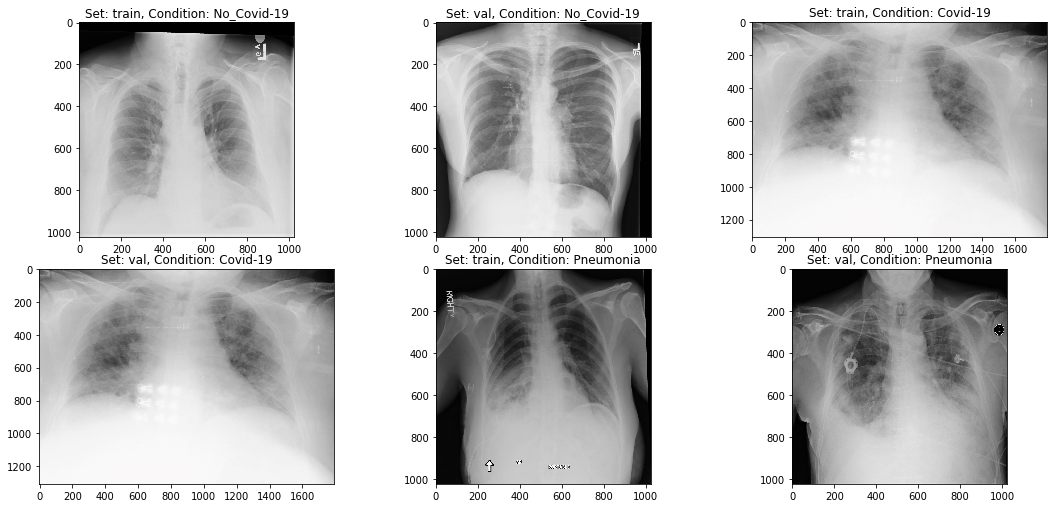

In [ ]:
# input_path = '../input/chest_xray/chest_xray/'
#input_path = '../input/chest-xray-pneumonia//chest_xray/chest_xray/'
input_path='C:/Users/tkauyu/Desktop/DATA ANALYTICS/MACHINE LEARNING/ASSIGNMENT PROJECT/COVID19/X-Ray_Image_dataset/'

fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/No_Covid-19/'+os.listdir(set_path+'/No_Covid-19')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: No_Covid-19'.format(_set))
    ax[i+2].imshow(plt.imread(set_path+'/Covid-19/'+os.listdir(set_path+'/Covid-19')[0]), cmap='gray')
    ax[i+2].set_title('Set: {}, Condition: Covid-19'.format(_set))
    ax[i+4].imshow(plt.imread(set_path+'/Pneumonia/'+os.listdir(set_path+'/Pneumonia')[0]), cmap='gray')
    ax[i+4].set_title('Set: {}, Condition: Pneumonia'.format(_set))

In [ ]:
# Distribution of our datasets
for _set in ['train', 'val']:
    n_normal = len(os.listdir(input_path + _set + '/No_Covid-19'))
    n_infect = len(os.listdir(input_path + _set + '/Covid-19'))
    n_pnemon = len(os.listdir(input_path + _set + '/Pneumonia'))
    print('Set: {}, No_Covid_19 images: {}, Covid_19 images: {},Pnemonia images: {}'.format(_set, n_normal, n_infect,n_pnemon))

Set: train, No_Covid_19 images: 491, Covid_19 images: 116,Pnemonia images: 491
Set: val, No_Covid_19 images: 500, Covid_19 images: 125,Pnemonia images: 500


In [ ]:
from os import listdir
data_list = listdir('C:/Users/tkauyu/Desktop/DATA ANALYTICS/MACHINE LEARNING/ASSIGNMENT PROJECT/COVID19/X-Ray_Image_dataset/train')

#Delete some classes that may interfere


data_list

['Covid-19', 'No_Covid-19', 'Pneumonia']

In [ ]:
#JOINING THE CODES
input_path_TRAIN='C:/Users/tkauyu/Desktop/DATA ANALYTICS/MACHINE LEARNING/ASSIGNMENT PROJECT/COVID19/X-Ray_Image_dataset/train'

#DATASET_PATH = '/content/two/train'
test_dir = 'C:/Users/tkauyu/Desktop/DATA ANALYTICS/MACHINE LEARNING/ASSIGNMENT PROJECT/COVID19/X-Ray_Image_dataset/val'


IMAGE_SIZE    = (150, 150)
NUM_CLASSES   = len(data_list)
BATCH_SIZE    = 10  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 22
LEARNING_RATE =0.0005


### ImageDataGenerator

The objective of ImageDataGenerator is to import data with labels easily into the model. It is a very useful class as it has many function to rescale, rotate, zoom, flip etc. The most useful thing about this class is that it doesn’t affect the data stored on the disk. This class alters the data on the go while passing it to the model.

In [ ]:


#Train datagen here is a preprocessor
train_datagen = ImageDataGenerator(rescale=1./255,
 rotation_range=50,
 featurewise_center = True,
 featurewise_std_normalization = True,
 width_shift_range=0.2,
 height_shift_range=0.2,
 shear_range=0.25,
 zoom_range=0.1,
 zca_whitening = True,
 channel_shift_range = 20,
 horizontal_flip = True ,
 vertical_flip = True ,
 validation_split = 0.2,
 fill_mode='constant')

# Flow training images in batches of 20 using train_datagen generator
train_batches = train_datagen.flow_from_directory(input_path_TRAIN,
 target_size=IMAGE_SIZE,
 shuffle=True,
 batch_size=BATCH_SIZE,
 subset = 'training',
 seed=42,
 class_mode='categorical',

 )

valid_batches = train_datagen.flow_from_directory(input_path_TRAIN,
 target_size=IMAGE_SIZE,
 shuffle=True,
 batch_size=BATCH_SIZE,
 subset = 'validation',
 seed=42,
 class_mode='categorical',

 )

Found 879 images belonging to 3 classes.
Found 219 images belonging to 3 classes.


## VGG16
In this model, we are going to use transfer learning using VGG16 architecture.


VGG-16 is one of the convolution neural net (CNN ) architecture which is considered as very good model for Image classification.
This model architecture was used in Image(ILSVR) competition in the year 2014.

#### VGG16 Architecture Map


In [ ]:
#Simple CNN model based on VGG16. Set dense layer neuron count to 3 if viral pneumonia class is removed


from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras import optimizers


# load the VGG16 network, ensuring the head FC layer sets are left off
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))


conv_base.trainable = False

optimizerzz = Adam(lr=0.0008, beta_1=0.9, beta_2=0.999)




  #optimizer=optimizers.Adam(lr=LEARNING_RATE)
# I will be using Sequential method as I am creating a sequential model. Sequential model means that all the layers
# of the model will be arranged in sequence.

model = models.Sequential()

# construct the head of the model that will be placed on top of the
# the base model

model.add(conv_base)
model.add(layers.Flatten())
#model.add(layers.Dense(255, activation='relu'))
#model.add(layers.Dense(255, activation='relu'))
#model.add(layers.Dense(800, activation='relu'))
model.add(layers.Dense(800, activation='relu'))
model.add(layers.Dense(800, activation='relu'))
model.add(layers.Dense(800, activation='relu'))
model.add(layers.Dense(800, activation='relu'))
model.add(layers.Dense(800, activation='relu'))
model.add(Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(3, activation='softmax'))


model.compile(loss='categorical_crossentropy',

              optimizer=optimizerzz,
              metrics=['acc'])

In [ ]:
print(model.summary())

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_28 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_71 (Dense)             (None, 800)               6554400   
_________________________________________________________________
dense_72 (Dense)             (None, 800)               640800    
_________________________________________________________________
dense_73 (Dense)             (None, 800)               640800    
_________________________________________________________________
dense_74 (Dense)             (None, 800)               640800    
_________________________________________________________________
dense_75 (Dense)             (None, 800)             

### Model CheckPointing and Early Stopping

In [ ]:
# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='acc', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='acc',  patience=3,mode='max')
#early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=2, mode='min')

## Training the model

In [ ]:
STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size



result=model.fit_generator(train_batches,
 steps_per_epoch =40,
 validation_data = valid_batches,
 validation_steps = STEP_SIZE_VALID,
 epochs= NUM_EPOCHS,callbacks=[checkpoint,lr_reduce],
 )
#, callbacks=[checkpoint,early_stop,lr_reduce]


Epoch 1/22
40/40 [==============================] - 81s 2s/step - loss: 0.9017 - acc: 0.5238 - val_loss: 0.9162 - val_acc: 0.4571 - lr: 8.0000e-04
Epoch 2/22
40/40 [==============================] - 81s 2s/step - loss: 0.8734 - acc: 0.5425 - val_loss: 0.9342 - val_acc: 0.4810 - lr: 8.0000e-04
Epoch 3/22
40/40 [==============================] - 82s 2s/step - loss: 0.8314 - acc: 0.5300 - val_loss: 0.7986 - val_acc: 0.6714 - lr: 8.0000e-04
Epoch 4/22
40/40 [==============================] - 81s 2s/step - loss: 0.7880 - acc: 0.6375 - val_loss: 0.8280 - val_acc: 0.6190 - lr: 8.0000e-04
Epoch 5/22
40/40 [==============================] - 81s 2s/step - loss: 0.7341 - acc: 0.6200 - val_loss: 0.7921 - val_acc: 0.6524 - lr: 8.0000e-04
Epoch 6/22
40/40 [==============================] - 82s 2s/step - loss: 0.8259 - acc: 0.6400 - val_loss: 0.7748 - val_acc: 0.5905 - lr: 8.0000e-04
Epoch 7/22
40/40 [==============================] - 82s 2s/step - loss: 0.7733 - acc: 0.6150 - val_loss: 0.7761 - val_

In [ ]:
STEP_SIZE_TRAIN

87

## Evaluation

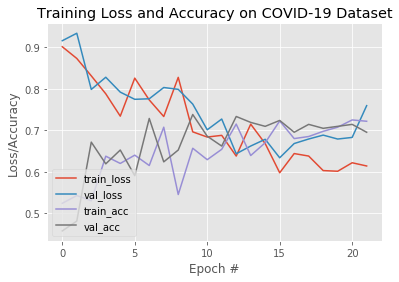

In [ ]:

# plot the training loss and accuracy
N = NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), result.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), result.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), result.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), result.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plt.savefig("plot")


In [ ]:
# serialize the model to disk
print("saving the model...")
#model.save("Covmodel", save_format="h5")
model.save("Covid_model_Predictor.h5")


saving the model...


In [ ]:
epoch_step=np.math.ceil(valid_batches.samples/valid_batches.batch_size)

predict=model.predict_generator(valid_batches,steps=epoch_step)

pred_classes=np.argmax(predict,axis=1)
pred_classes

Instructions for updating:
Please use Model.predict, which supports generators.


array([1, 1, 1, 2, 1, 2, 1, 2, 0, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2,
       0, 2, 0, 2, 1, 2, 2, 1, 1, 0, 1, 1, 1, 1, 1, 2, 2, 0, 1, 1, 1, 2,
       1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1,
       2, 2, 1, 1, 2, 1, 2, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2,
       2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1,
       1, 2, 0, 2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 0, 1, 2, 2, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1, 1,
       2, 2, 2, 1, 0, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1,
       2, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1,
       2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 0, 1],
      dtype=int64)

In [ ]:
valid_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [ ]:
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics

og_classes=valid_batches.classes
labels=list(valid_batches.class_indices.keys())

metrics_rep=metrics.classification_report(og_classes,pred_classes,target_names=labels)
print(metrics_rep)

              precision    recall  f1-score   support

    Covid-19       0.13      0.09      0.11        23
 No_Covid-19       0.42      0.53      0.47        98
   Pneumonia       0.41      0.34      0.37        98

    accuracy                           0.40       219
   macro avg       0.32      0.32      0.31       219
weighted avg       0.39      0.40      0.39       219



Pneumonia
[2]


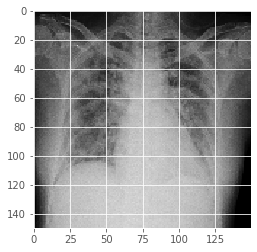

In [ ]:
# testing the model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image

from tensorflow.keras.models import load_model

test_path="C:/Users/tkauyu/Desktop/DATA ANALYTICS/MACHINE LEARNING/ASSIGNMENT PROJECT/COVID19/X-Ray_Image_dataset/val/testimg.jpg"

img=image.load_img(test_path,target_size=(150,150))
img=np.asarray(img)
plt.imshow(img)

img=np.expand_dims(img,axis=0)

mymodel=load_model('Covid_model_Predictor.h5')
result=mymodel.predict(img)

pred_class=np.argmax(result,axis=1)
#result[0][0]

if pred_class == 0:
    prediction = 'Covid-19'
elif pred_class ==1:
    prediction= 'No_Covid-19'
elif pred_class==2:
    prediction= 'Pneumonia'
else:
    prediction = 'Unknown'

print(prediction)
print(pred_class)



### Fine Tunning

In [ ]:

model.compile(loss='categorical_crossentropy',

              optimizer=optimizers.Adam(lr=5e-5),
              metrics=['acc'])

result=model.fit_generator(train_batches,
                        steps_per_epoch =STEP_SIZE_TRAIN,
                        validation_data = valid_batches,
                        validation_steps = STEP_SIZE_VALID,
                        epochs= 20,
                       )


Epoch 1/20
87/87 [==============================] - 133s 2s/step - loss: 0.5481 - acc: 0.7388 - val_loss: 0.6561 - val_acc: 0.7238
Epoch 2/20
87/87 [==============================] - 134s 2s/step - loss: 0.5421 - acc: 0.7675 - val_loss: 0.5345 - val_acc: 0.7762
Epoch 3/20
87/87 [==============================] - 134s 2s/step - loss: 0.5156 - acc: 0.7641 - val_loss: 0.6079 - val_acc: 0.7571
Epoch 4/20
87/87 [==============================] - 134s 2s/step - loss: 0.5136 - acc: 0.7675 - val_loss: 0.6306 - val_acc: 0.7190
Epoch 5/20
87/87 [==============================] - 134s 2s/step - loss: 0.5562 - acc: 0.7422 - val_loss: 0.6035 - val_acc: 0.7286
Epoch 6/20
87/87 [==============================] - 134s 2s/step - loss: 0.5315 - acc: 0.7491 - val_loss: 0.6128 - val_acc: 0.7952
Epoch 7/20
87/87 [==============================] - 136s 2s/step - loss: 0.5074 - acc: 0.7791 - val_loss: 0.6579 - val_acc: 0.7524
Epoch 8/20
87/87 [==============================] - 159s 2s/step - loss: 0.5196 - a

In [ ]:
eval_generator.reset()
x = model.evaluate_generator(eval_generator,
                           steps = np.ceil(len(eval_generator) / BATCH_SIZE),
                           use_multiprocessing = False,
                           verbose = 1,
                           workers=1
                           )


print('Test loss:' , x[0])
print('Test accuracy:',x[1])


2/2 [==============================] - 0s 64ms/step - loss: 0.4944 - acc: 0.5000
Test loss: 0.4943535029888153
Test accuracy: 0.5


In [ ]:
# prompt: Can l have a detailed summary of the whole code in this notebook file

This Python code is a comprehensive script for building and evaluating a Convolutional Neural Network (CNN) model to predict COVID-19, No COVID-19, and Pneumonia from chest X-ray images. Here's a detailed summary:

**1. Setup and Imports:**

- **Library Imports:** The code begins by importing necessary libraries for data manipulation (NumPy, Pandas), image processing (OpenCV, Matplotlib), deep learning (TensorFlow, Keras), model evaluation (Scikit-learn), and file system operations (os).
- **Configuration:** It sets a random seed for reproducibility and initializes various parameters like `IMAGE_SIZE`, `NUM_CLASSES`, `BATCH_SIZE`, `NUM_EPOCHS`, and `LEARNING_RATE`.
- **Warnings:** It filters out warnings to keep the output clean.

**2. Exploratory Data Analysis (EDA):**

- **Data Path:** Sets the input path to the dataset containing the X-ray images, categorized into 'train' and 'val' sets, and further into 'No_Covid-19', 'Covid-19', and 'Pneumonia'.
- **Image Visualization:** Displays sample images from each category ('No_Covid-19', 'Covid-19', and 'Pneumonia') for both the training and validation sets using Matplotlib. This provides a visual understanding of the data.
- **Dataset Distribution:** Prints the number of images in each category for the training and validation sets to show the distribution of the classes.

**3. Data Preparation and Augmentation:**

- **ImageDataGenerator:** Initializes an `ImageDataGenerator` object. This is a crucial step for data augmentation, which helps in increasing the size and diversity of the training dataset by applying random transformations (rotation, shifting, shearing, zooming, flipping, etc.) to the images. It also handles image rescaling.
- **Data Loading:** Uses `flow_from_directory` to load images from the specified training directory (`input_path_TRAIN`). It automatically infers the labels based on the directory structure.
- **Training and Validation Batches:** Creates `train_batches` and `valid_batches` using the `ImageDataGenerator`. These generators provide batches of augmented images and their corresponding labels to the model during training and validation. The dataset is split into training and validation sets based on the `validation_split` parameter.

**4. Model Building (VGG16 with Transfer Learning):**

- **Transfer Learning:** Utilizes the pre-trained VGG16 convolutional base from the `imagenet` dataset. This is a common transfer learning technique where a model trained on a large dataset is used as a starting point for a new task.
- **Freezing Layers:** Sets `conv_base.trainable = False` to freeze the weights of the pre-trained VGG16 layers. This prevents the pre-trained weights from being updated during the initial training phase, preserving the learned features.
- **Building the Classifier:** Constructs a sequential model by adding the VGG16 convolutional base followed by flattening the output and adding several dense layers with ReLU activation. Dropout layers are included to prevent overfitting. The final dense layer has 3 neurons (corresponding to the three classes) and a softmax activation for multi-class classification.
- **Model Compilation:** Compiles the model using the Adam optimizer, categorical cross-entropy loss (suitable for multi-class classification), and 'acc' (accuracy) as the evaluation metric.

**5. Training the Model:**

- **Callbacks:** Defines callbacks for training:
    - `ModelCheckpoint`: Saves the model's weights only when there is an improvement in the validation accuracy.
    - `ReduceLROnPlateau`: Reduces the learning rate when the accuracy plateaus, helping the model to converge further.
    - `EarlyStopping`: Stops the training early if the accuracy does not improve for a certain number of epochs (optional, commented out in the provided code).
- **Training Execution:** Trains the model using `fit_generator`, which takes the training and validation data generators as input. It specifies the number of steps per epoch and the total number of epochs. Callbacks are passed to monitor the training process.

**6. Evaluation and Prediction:**

- **Training History Plot:** Plots the training and validation loss and accuracy over the epochs using Matplotlib. This visualization helps in understanding the model's performance during training and identifying potential overfitting or underfitting.
- **Model Saving:** Saves the trained model to a file (`Covid_model_Predictor.h5`) in HDF5 format.
- **Prediction on Validation Set:** Generates predictions on the validation set using `predict_generator`.
- **Classification Report:** Calculates and prints a detailed classification report using Scikit-learn's `classification_report`. This report includes precision, recall, F1-score, and support for each class, providing a comprehensive evaluation of the model's performance.
- **Testing with a Single Image:** Loads a test image, preprocesses it, and uses the trained model to predict the class of the image. It then prints the predicted class.

**7. Fine-Tuning (Optional):**

- **Unfreezing Layers (Implicit):** Although not explicitly shown by setting `conv_base.trainable = True`, the commented-out section for fine-tuning would typically involve unfreezing some or all layers of the convolutional base and retraining the model with a smaller learning rate to further improve performance by adapting the pre-trained weights to the specific dataset.
- **Retraining:** Retrains the model with a potentially lower learning rate for a few more epochs.
- **Evaluation after Fine-Tuning:** Evaluates the fine-tuned model on the validation set.

**Overall, this code provides a standard workflow for image classification using deep learning, including data loading, augmentation, transfer learning with a pre-trained VGG16 model, training, evaluation, and prediction.**